In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx

from community import community_louvain
from sklearn.decomposition import PCA

from network import Network
from data import get_MNIST_data_loaders
from train import train_network
from evaluate import accuracy
from utils import reshape_image

In [2]:
def load_network(fname):
    state = torch.load(fname)
    model = Network(
        1 if state["variant"] == "p" else 28, 
        state["hidden_dim"], 
        10,
        freeze_neurons=state["freeze_neurons"], 
        freeze_g=state["freeze_activations"]
    )
    model.load_state_dict(state["model_state_dict"])
    return model

In [3]:
variant = "l"
train_loader, test_loader = get_MNIST_data_loaders(256, variant=variant)

In [5]:
model = load_network("model/network_params/l_256_True_True.pt")

In [51]:
def get_trajectory(model, dataloader):
    states = []
    ys = []
    with torch.no_grad():
        for x, label in dataloader:
            fs = []
            x = reshape_image(x, variant=variant)
            
            # sequentially send input into network
            model.reset(x.shape[0])
            for i in range(x.shape[1]):
                model(x[:, i, :])
                fs.append(model.hidden_neurons.fs.detach().clone())
    
            total_pred = torch.zeros(x.shape[0], 10)
            for _ in range(5):
                pred_y = model(model.zero_input(x.shape[0]))
                fs.append(model.hidden_neurons.fs.detach().clone())
            states.append(fs)
            ys.append(label)
    return states, ys

In [11]:
states, ys = get_trajectory(model, test_loader)
ys = np.concatenate(ys)

In [21]:
new_states = []
for s in states:
    new_states.append(torch.stack(s, dim=2))
all_seqs = torch.cat(new_states, dim=0) # [batch, n_neurons, seq]

In [89]:
xs = []
for i in range(all_seqs.shape[0]):
    for j in range(all_seqs.shape[2]):
        xs.append(all_seqs[i, :, j].numpy())

In [90]:
pca = PCA(n_components=2).fit(xs)
pca.explained_variance_ratio_

array([0.42127871, 0.08146667])

In [91]:
all_trajs = []
for i in range(all_seqs.shape[0]):
    traj = []
    for j in range(all_seqs.shape[2]):
        traj.append(pca.transform([all_seqs[i, :, j].numpy()])[0])
    all_trajs.append(traj)

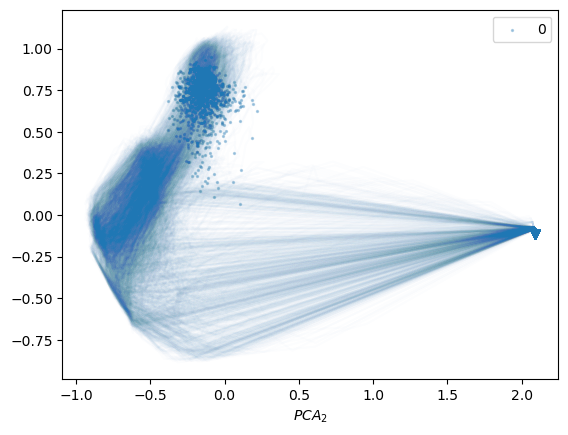

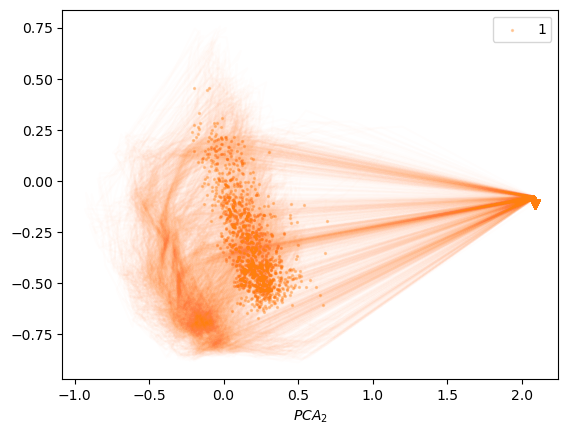

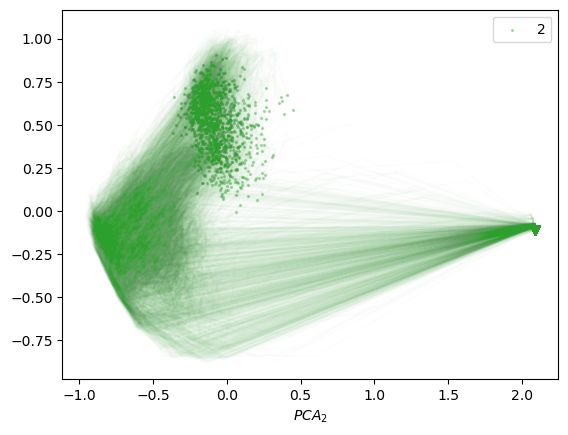

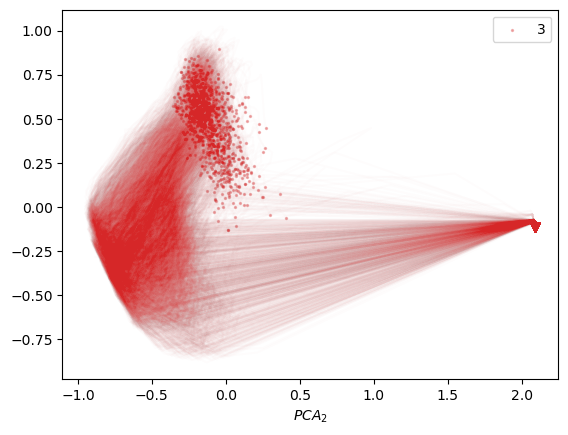

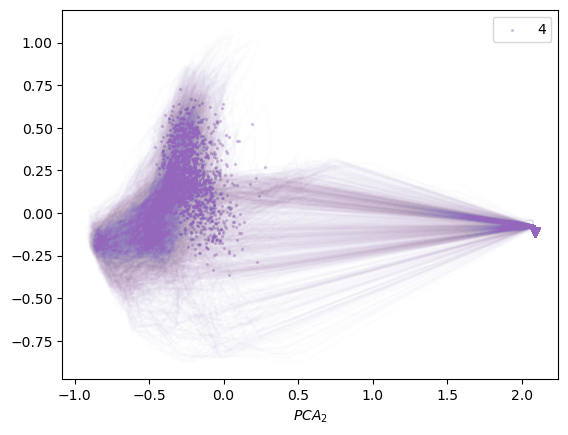

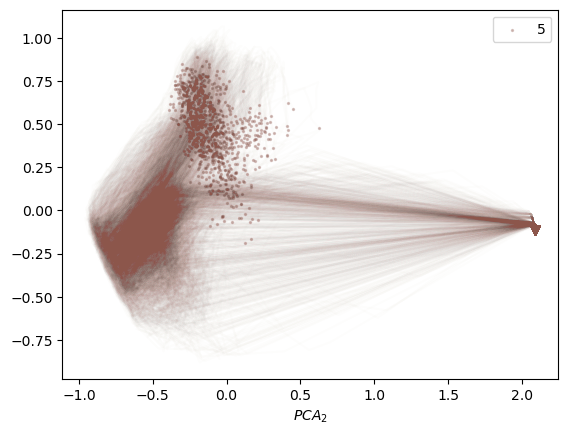

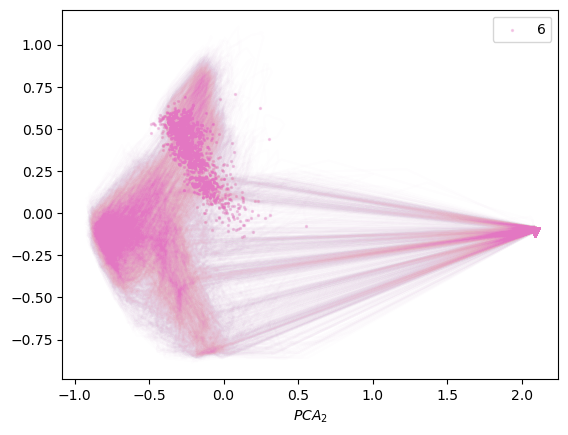

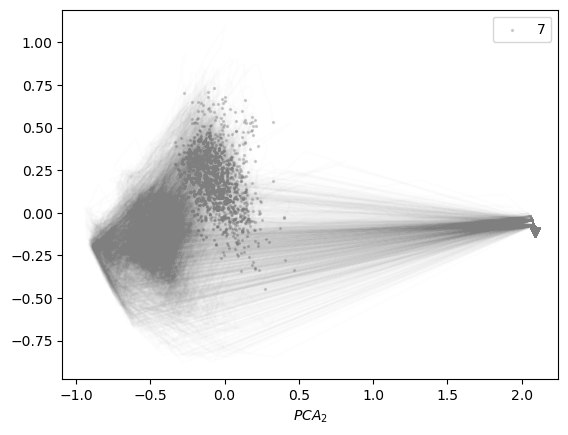

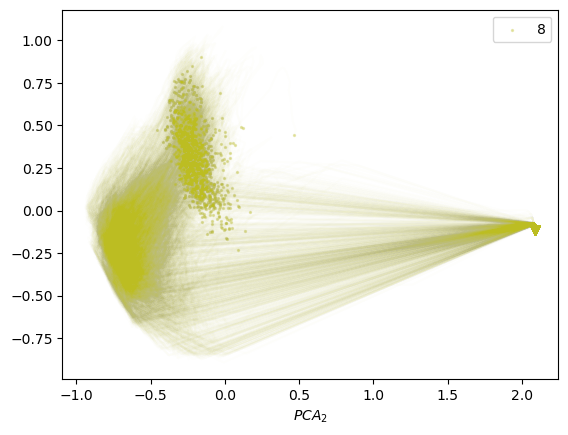

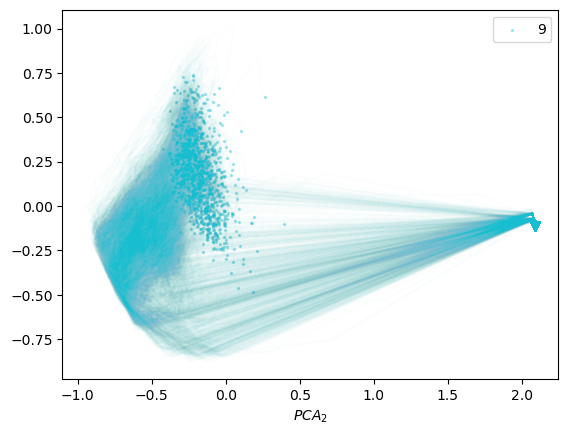

In [102]:
cs = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
N = 10000
zs = np.array(all_trajs)[:N]
ws = ys[:N]
for i in range(10):
    plt.figure()
    zsi = zs[ws == i, :, :]
    for j in range(zsi.shape[0]):
        plt.plot(zsi[j, :, 0], zsi[j, :, 1], c=cs[i], alpha=0.01)
    plt.scatter(zsi[:, 0, 0], zsi[:, 0, 1], c=cs[i], marker="v")
    plt.scatter(zsi[:, -1, 0], zsi[:, -1, 1], c=cs[i], label=f"{i}", alpha=0.3, s=2)
    plt.xlabel("$PCA_1$")
    plt.xlabel("$PCA_2$")
    plt.legend();

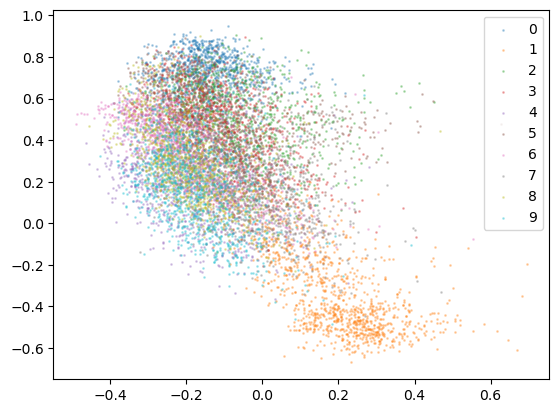

In [99]:
cs = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
N = 10000
zs = np.array(all_trajs)[:N]
ws = ys[:N]
for i in range(10):
    zsi = zs[ws == i, :, :]
    plt.scatter(zsi[:, -1, 0], zsi[:, -1, 1], c=cs[i], label=f"{i}", alpha=0.3, s=1.5)
plt.legend();

In [ ]:
with torch.no_grad():
    fs = []
    for x, label in test_loader:
        x = reshape_image(x, variant=variant)
        
        # sequentially send input into network
        model.reset(x.shape[0])
        for i in range(x.shape[1]):
            model(x[:, i, :])
            fs.append(model.hidden_neurons.fs)

        total_pred = torch.zeros(x.shape[0], 10)
        for _ in range(5):
            pred_y = model(model.zero_input(x.shape[0]))
            fs.append(model.hidden_neurons.fs)
        break

0


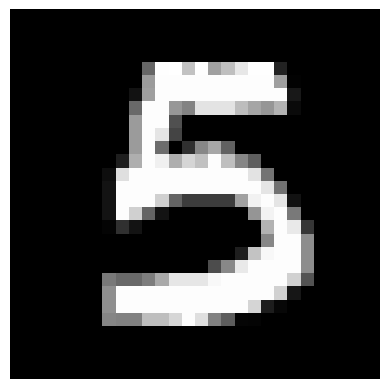

1


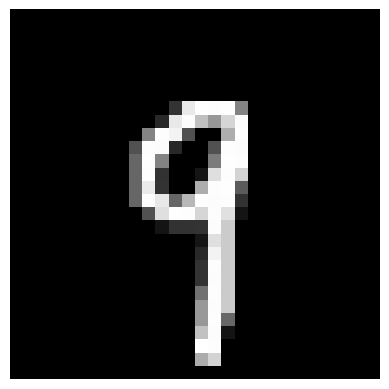

2


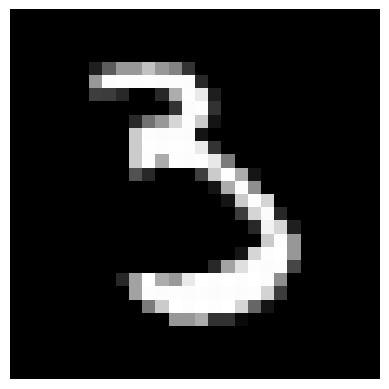

3


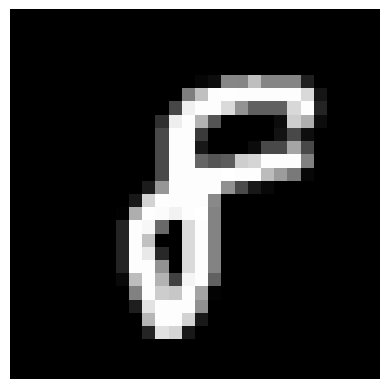

4


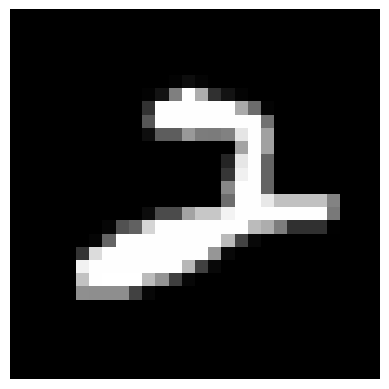

5


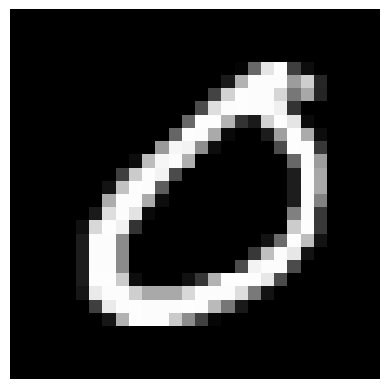

6


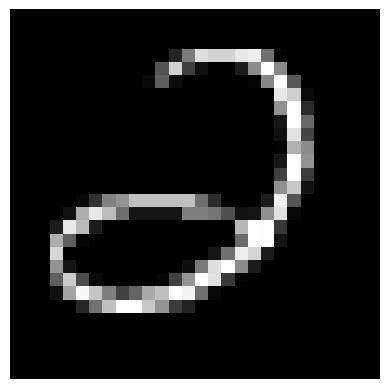

7


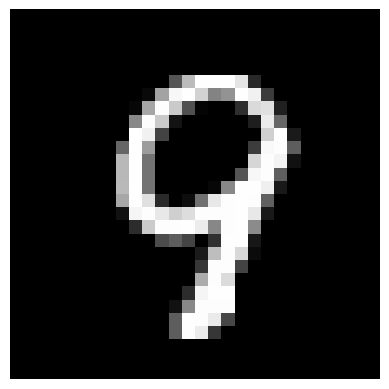

8


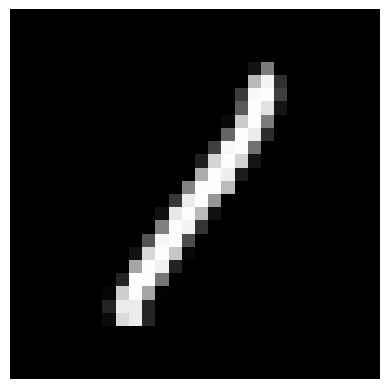

9


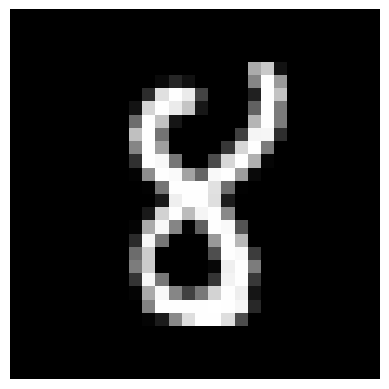

10


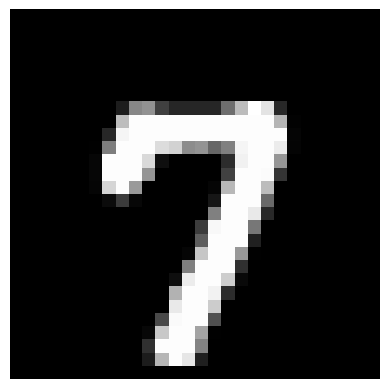

11


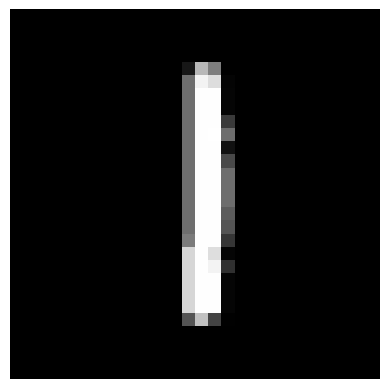

12


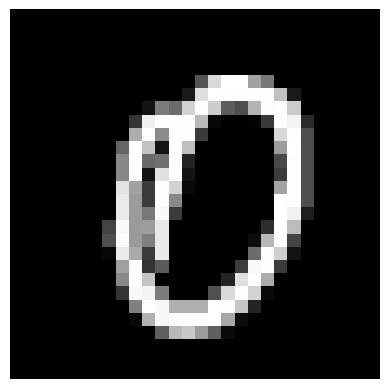

13


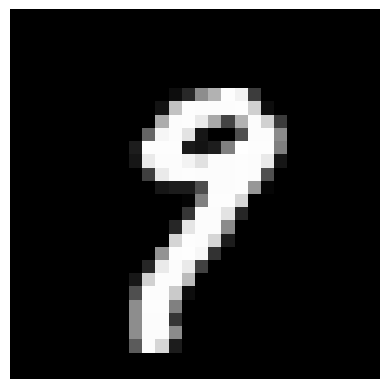

14


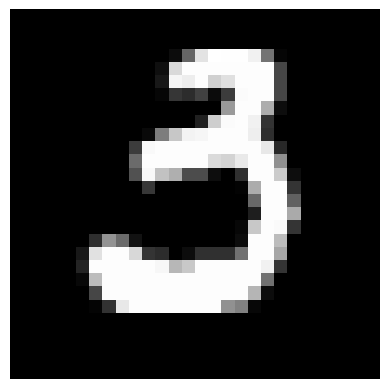

15


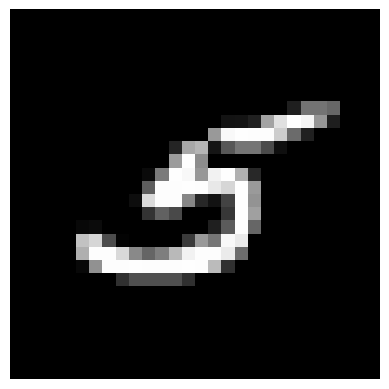

16


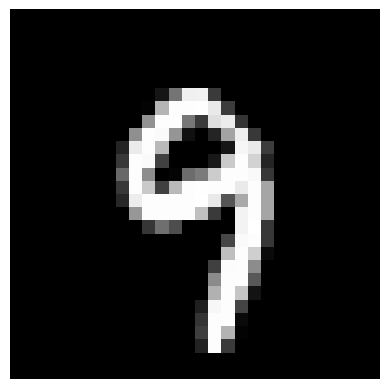

17


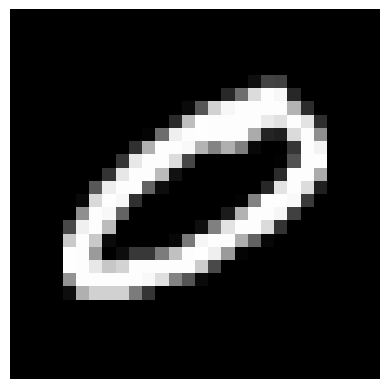

18


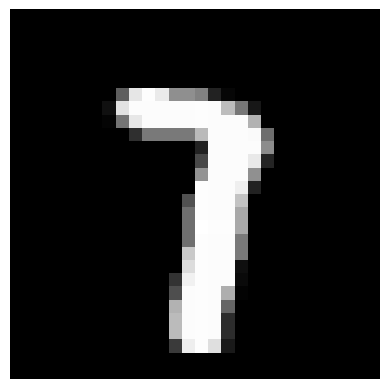

19


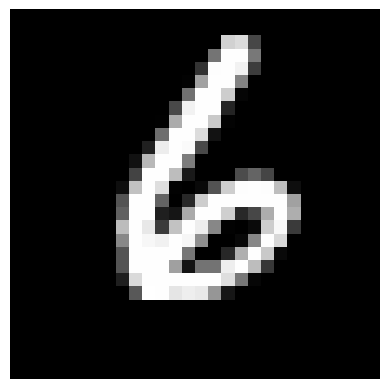

In [15]:
for i in range(20):
    print(i)
    plt.figure()
    plt.imshow(x.detach()[i, :, :], cmap="gray")
    plt.axis("off")
    plt.show()

In [16]:
i = 0

In [17]:
As = torch.stack([f[i,:] for f in fs])
with torch.no_grad():
    w = F.softmax(model.fc3(fs[-1][i,:]), dim=0)

(-0.5, 27.5, 27.5, -0.5)

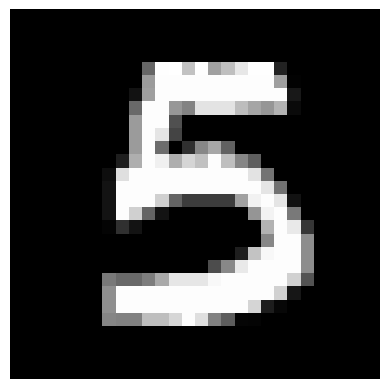

In [18]:
plt.imshow(x.detach()[i, :, :], cmap="gray")
plt.axis("off")

/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_14353/784502518.py:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=1.0)


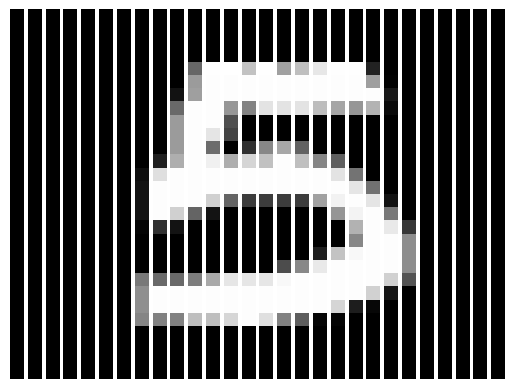

In [19]:
fig, axs = plt.subplots(1, 28)
fig.tight_layout(pad=1.0)
for j in range(28):
    axs[j].imshow(x.detach()[i, :, j].reshape(28, 1), cmap="gray", vmin=0, vmax=1)
    axs[j].axis("off")

In [20]:
x.shape

torch.Size([256, 28, 28])

/var/folders/_r/m9hbjyhd13bbv3lg031lk0fc0000gn/T/ipykernel_14353/3399382440.py:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=1.0)


RuntimeError: shape '[24, 24]' is invalid for input of size 784

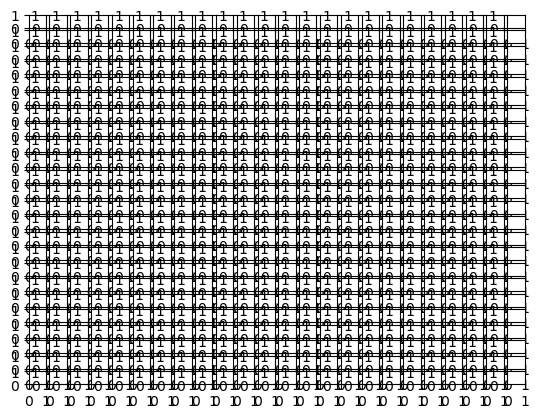

In [21]:
fig, axs = plt.subplots(24, 24)
fig.tight_layout(pad=1.0)
for j in range(24):
    for k in range(24):
        axs[j, k].imshow(x.detach()[i, :, :].reshape(24, 24)[j, k].reshape(1, 1), cmap="gray", vmin=0, vmax=1)
        axs[j, k].axis("off")

In [22]:
A = model.fc2.weight.detach().abs().numpy()
G = nx.from_numpy_array(A)
partition = community_louvain.best_partition(G)

order = []
for v in np.unique(list(partition.values())):
    for k in partition:
        if partition[k] == v:
            order.append(k)

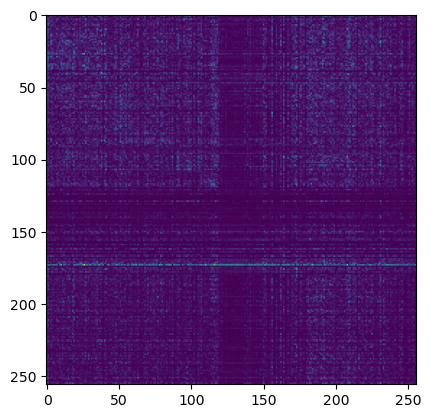

In [23]:
plt.imshow(A[order, :][:, order])

Text(0, 0.5, 'neuron')

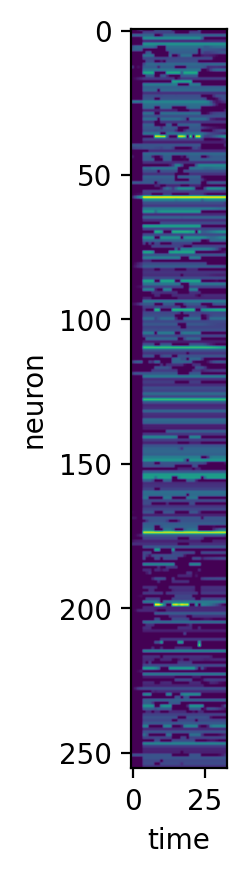

In [24]:
plt.figure(dpi=200)
plt.imshow(As.T[order, :])
#plt.imshow(As.T)
plt.xlabel("time")
plt.ylabel("neuron")

In [ ]:
plt.figure(dpi=200)
plt.imshow(w.reshape(-1, 1))
#plt.yticks(ticks=np.arange(0, 10), minor=True)
plt.yticks(np.arange(10), [str(i) for i in range(10)])
plt.xticks([]);